## Volatility Prediction
#### Maria Kravchenko, Mackenzie Qu, Victor Hsu

In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from featureStudy import get_files

In [2]:
HOME_PATH = os.environ['HOME']
OUTPUT_PATH = os.path.join(HOME_PATH, 'research', 'milestone1')
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print(f"Created directory: {OUTPUT_PATH}")

### BTCUSDT

Load level1 time series.

In [3]:
exchange = "binance"

start_date = "20240101"
end_date = "20240701"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

level1_data = get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT")
print("Level1 Keys:", level1_data.keys())

Level1 Keys: Index(['ts_end', 'bin_id', 'carryover', 'ramp_up', 'tick_count', 'l3_updates',
       'open_mid', 'first_mid', 'close_mid', 'min_mid', 'max_mid', 'close_bid',
       'close_ask', 'close_bid_size', 'close_ask_size', 'max_bid', 'min_ask',
       'ask_up_ret', 'ask_down_ret', 'bid_up_ret', 'bid_down_ret',
       'median_spread', 'mean_spread', 'min_spread', 'max_spread',
       'mean_bid_size', 'mean_ask_size', 'tick_volatility'],
      dtype='object')


Calculate your favorite volatility estimator.

In [4]:
level1_data["ret"] = np.log(level1_data["close_mid"]).diff()
level1_data["realized_vol"] = level1_data["ret"].rolling(60).std() * np.sqrt(60)
level1_data['realized_vol']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1435    0.002226
1436    0.002312
1437    0.002319
1438    0.002310
1439    0.002328
Name: realized_vol, Length: 263520, dtype: float64

Plot volatility seasonality over 24 hours day time.

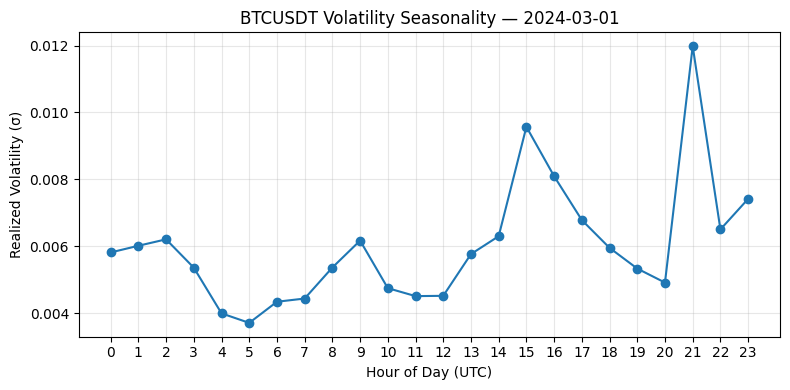

In [5]:
level1_data["datetime"] = pd.to_datetime(level1_data["ts_end"], unit="ms", utc=True)
level1_data["date"] = level1_data["datetime"].dt.date
level1_data["hour"] = level1_data["datetime"].dt.hour

target_date = pd.to_datetime("2024-03-01").date()
day_data = level1_data[level1_data["date"] == target_date].copy()

hourly_volatility_1d = (
    day_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_volatility_1d["hour"], hourly_volatility_1d["realized_vol"], marker="o")
plt.title(f"BTCUSDT Volatility Seasonality — {target_date}")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "btc_vol_seasonality_1d.png")
plt.savefig(save_path, dpi=300)

plt.show()

Average this plot over ~6 months of data

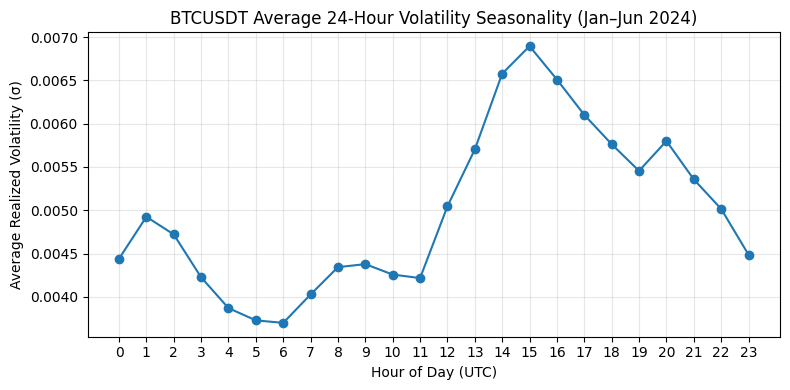

In [6]:
hourly_seasonality_6m = (
    level1_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_seasonality_6m["hour"], hourly_seasonality_6m["realized_vol"],
         marker="o", color="tab:blue")
plt.title("BTCUSDT Average 24-Hour Volatility Seasonality (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "btc_vol_seasonality_6m.png")
plt.savefig(save_path, dpi=300)

plt.show()

Show the difference between weekdays and weekends.

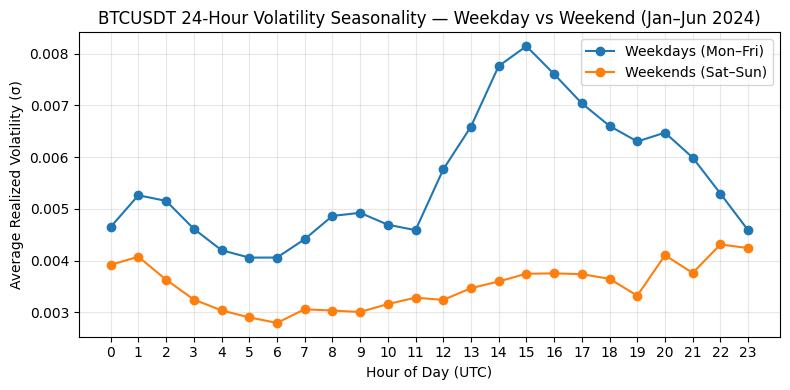

In [7]:
level1_data["dayofweek"] = level1_data["datetime"].dt.dayofweek
level1_data["is_weekend"] = level1_data["dayofweek"] >= 5

weekday_data  = level1_data[~level1_data["is_weekend"]]
weekend_data  = level1_data[level1_data["is_weekend"]]

weekday_seasonality = (
    weekday_data.groupby("hour")["realized_vol"].mean().reset_index()
)
weekend_seasonality = (
    weekend_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(weekday_seasonality["hour"], weekday_seasonality["realized_vol"],
         marker="o", label="Weekdays (Mon–Fri)", color="tab:blue")
plt.plot(weekend_seasonality["hour"], weekend_seasonality["realized_vol"],
         marker="o", label="Weekends (Sat–Sun)", color="tab:orange")
plt.title("BTCUSDT 24-Hour Volatility Seasonality — Weekday vs Weekend (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "btc_vol_seasonality_wkday_wkend.png")
plt.savefig(save_path, dpi=300)

plt.show()

Show the difference introduced by US light saving switch

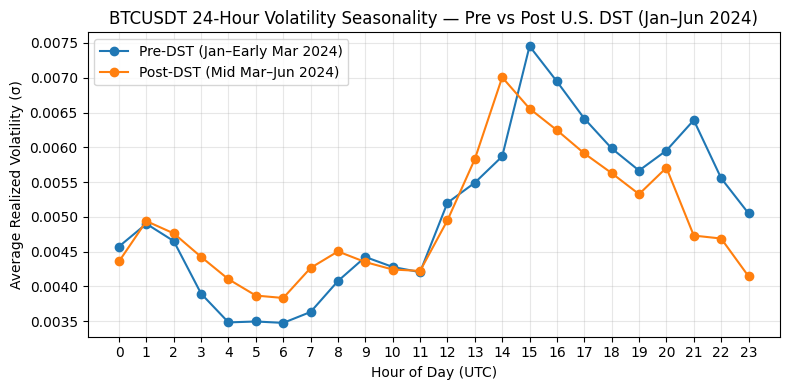

In [8]:
dst_switch_date = pd.to_datetime("2024-03-10").date()

pre_dst_data  = level1_data[level1_data["date"] < dst_switch_date]
post_dst_data = level1_data[level1_data["date"] >= dst_switch_date]

pre_dst_seasonality = (
    pre_dst_data.groupby("hour")["realized_vol"].mean().reset_index()
)
post_dst_seasonality = (
    post_dst_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(pre_dst_seasonality["hour"], pre_dst_seasonality["realized_vol"],
         marker="o", label="Pre-DST (Jan–Early Mar 2024)", color="tab:blue")
plt.plot(post_dst_seasonality["hour"], post_dst_seasonality["realized_vol"],
         marker="o", label="Post-DST (Mid Mar–Jun 2024)", color="tab:orange")
plt.title("BTCUSDT 24-Hour Volatility Seasonality — Pre vs Post U.S. DST (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "btc_vol_seasonality_pre_post_dst.png")
plt.savefig(save_path, dpi=300)

plt.show()

### ETH

Load level1 time series.

In [9]:
exchange = "binance"

start_date = "20240101"
end_date = "20240701"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

level1_data = get_files(start_dt, end_dt, "level1", exchange, "futures", "ETHUSDT")
print("Level1 Keys:", level1_data.keys())

[FILE NOT FOUND] /home/data/data/time_series/market_data/binance/futures/latest/level1_1min/20240113/ETHUSDT.20240113.level1.1min.csv.gz
[FILE NOT FOUND] /home/data/data/time_series/market_data/binance/futures/latest/level1_1min/20240114/ETHUSDT.20240114.level1.1min.csv.gz
Level1 Keys: Index(['ts_end', 'bin_id', 'carryover', 'ramp_up', 'tick_count', 'l3_updates',
       'open_mid', 'first_mid', 'close_mid', 'min_mid', 'max_mid', 'close_bid',
       'close_ask', 'close_bid_size', 'close_ask_size', 'max_bid', 'min_ask',
       'ask_up_ret', 'ask_down_ret', 'bid_up_ret', 'bid_down_ret',
       'median_spread', 'mean_spread', 'min_spread', 'max_spread',
       'mean_bid_size', 'mean_ask_size', 'tick_volatility'],
      dtype='object')


Calculate your favorite volatility estimator.

In [10]:
level1_data["ret"] = np.log(level1_data["close_mid"]).diff()
level1_data["realized_vol"] = level1_data["ret"].rolling(60).std() * np.sqrt(60)
level1_data['realized_vol']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1435    0.002826
1436    0.002880
1437    0.002881
1438    0.002807
1439    0.002860
Name: realized_vol, Length: 260640, dtype: float64

Plot volatility seasonality over 24 hours day time.

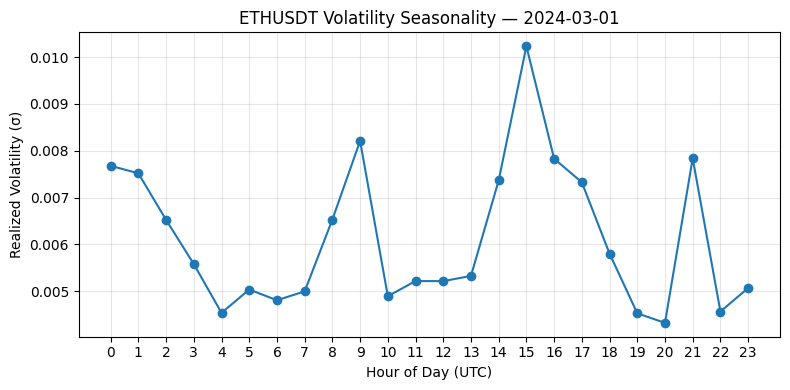

In [11]:
level1_data["datetime"] = pd.to_datetime(level1_data["ts_end"], unit="ms", utc=True)
level1_data["date"] = level1_data["datetime"].dt.date
level1_data["hour"] = level1_data["datetime"].dt.hour

target_date = pd.to_datetime("2024-03-01").date()
day_data = level1_data[level1_data["date"] == target_date].copy()

hourly_volatility_1d = (
    day_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_volatility_1d["hour"], hourly_volatility_1d["realized_vol"], marker="o")
plt.title(f"ETHUSDT Volatility Seasonality — {target_date}")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "eth_vol_seasonality_1d.png")
plt.savefig(save_path, dpi=300)

plt.show()

Average this plot over ~6 months of data

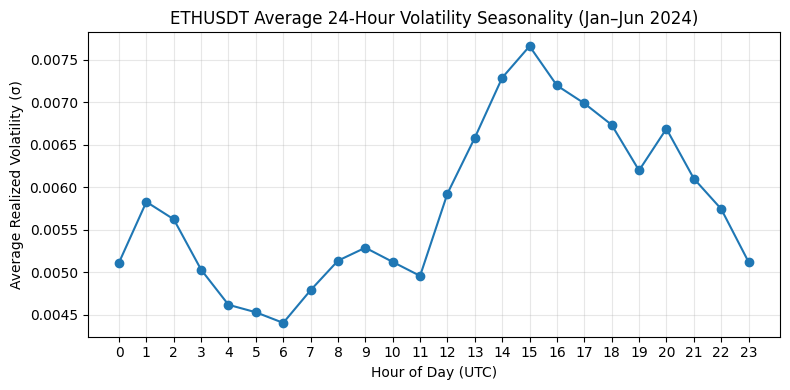

In [12]:
hourly_seasonality_6m = (
    level1_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_seasonality_6m["hour"], hourly_seasonality_6m["realized_vol"],
         marker="o", color="tab:blue")
plt.title("ETHUSDT Average 24-Hour Volatility Seasonality (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "eth_vol_seasonality_6m.png")
plt.savefig(save_path, dpi=300)

plt.show()

Show the difference between weekdays and weekends.

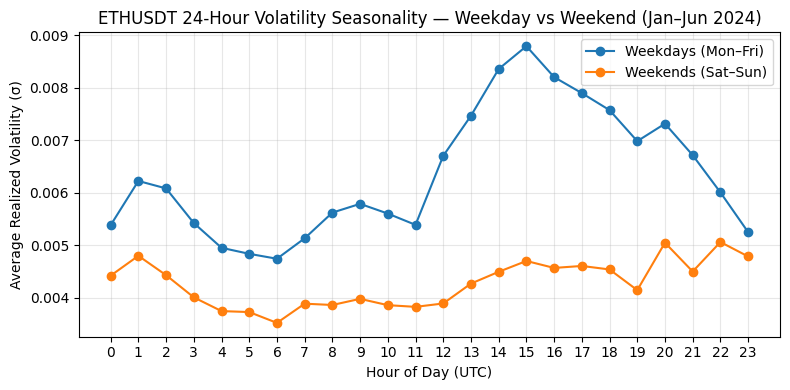

In [13]:
level1_data["dayofweek"] = level1_data["datetime"].dt.dayofweek
level1_data["is_weekend"] = level1_data["dayofweek"] >= 5

weekday_data  = level1_data[~level1_data["is_weekend"]]
weekend_data  = level1_data[level1_data["is_weekend"]]

weekday_seasonality = (
    weekday_data.groupby("hour")["realized_vol"].mean().reset_index()
)
weekend_seasonality = (
    weekend_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(weekday_seasonality["hour"], weekday_seasonality["realized_vol"],
         marker="o", label="Weekdays (Mon–Fri)", color="tab:blue")
plt.plot(weekend_seasonality["hour"], weekend_seasonality["realized_vol"],
         marker="o", label="Weekends (Sat–Sun)", color="tab:orange")
plt.title("ETHUSDT 24-Hour Volatility Seasonality — Weekday vs Weekend (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "eth_vol_seasonality_wkday_wkend.png")
plt.savefig(save_path, dpi=300)

plt.show()

Show the difference introduced by US light saving switch

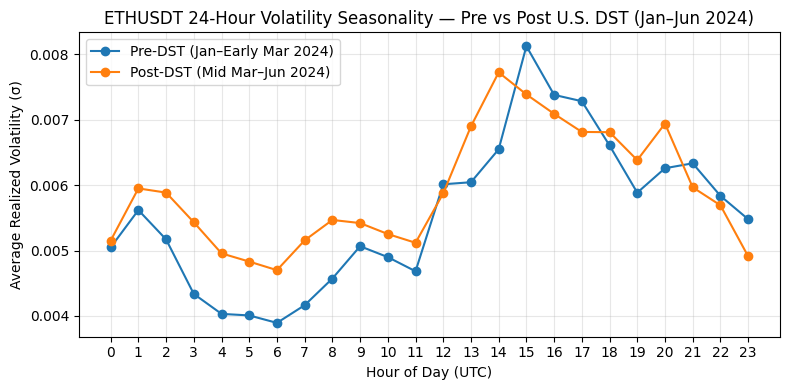

In [14]:
dst_switch_date = pd.to_datetime("2024-03-10").date()

pre_dst_data  = level1_data[level1_data["date"] < dst_switch_date]
post_dst_data = level1_data[level1_data["date"] >= dst_switch_date]

pre_dst_seasonality = (
    pre_dst_data.groupby("hour")["realized_vol"].mean().reset_index()
)
post_dst_seasonality = (
    post_dst_data.groupby("hour")["realized_vol"].mean().reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(pre_dst_seasonality["hour"], pre_dst_seasonality["realized_vol"],
         marker="o", label="Pre-DST (Jan–Early Mar 2024)", color="tab:blue")
plt.plot(post_dst_seasonality["hour"], post_dst_seasonality["realized_vol"],
         marker="o", label="Post-DST (Mid Mar–Jun 2024)", color="tab:orange")
plt.title("ETHUSDT 24-Hour Volatility Seasonality — Pre vs Post U.S. DST (Jan–Jun 2024)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Realized Volatility (σ)")
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUTPUT_PATH, "eth_vol_seasonality_pre_post_dst.png")
plt.savefig(save_path, dpi=300)

plt.show()